# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Returns of securities around FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

All returns and returns-statistics were calculated via basis points and not returns

## Packages

In [6]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [7]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FOMCDrift/root/src")

from FOMCDataPreprocess import FOMCPreprocess
from EventDrivenSignalGenerator import EventDrivenSignalGenerator

## Data Prep

In [226]:
def _prep_mai() -> pd.DataFrame: 

    groups = ["monetary", "unemp"]
    
    df_out = (FOMCPreprocess().prep_mai().query(
        "group == 'daily_data'").
        drop(columns = ["group", "value", "group_var"]).
        query("sentiment_type == @groups").
        drop(columns = ["sentiment_source", "sentiment_type"])
        [["date", "variable", "z_score"]].
        rename(columns = {"variable": "security"}).
        assign(
            name      = lambda x: np.where(x.security.str.split("_").str[0] == "unemp", "Unemployment", "Monetary"),
            source    = lambda x: x.security.str.split("_").str[-1],
            plot_name = lambda x: x.name.str.capitalize() + " Sentiment: \n" + np.where(x.source == "ni", "NYTimes", "WSJ")).
        drop(columns = ["source", "name"]))

    return df_out

In [228]:
def get_tsy() -> pd.DataFrame: 
    
    df_tsy = (EventDrivenSignalGenerator().get_tsy_futures().rename(
        columns = {"security": "variable"}).
        assign(variable = lambda x: x.variable.str.split(" ").str[0]))
    
    return df_tsy

def get_tsy_window(df_tsy: pd.DataFrame, before: int = -6, after: int = 1) -> pd.DataFrame:
    
    df_out = (EventDrivenSignalGenerator().get_ordered_window(
        df     = df_tsy,
        before = before,
        after  = after).
        merge(right = _prep_mai(), how = "inner", on = ["date"]))
    
    return df_out

df_tsy    = get_tsy()
df_window = get_tsy_window(df_tsy)

In [229]:
def nlp_conditioned_zscore(df_window: pd.DataFrame, window: int = -4) -> pd.DataFrame:  
    
    df_prep = (df_window.query(
        "day == @window")
        [["event", "security", "z_score"]].
        drop_duplicates().
        rename(columns = {"z_score": "condition"}).
        merge(right = df_window, how = "inner", on = ["event", "security"])
        [["security", "condition", "variable", "PX_bps", "plot_name", "day"]].
        assign(condition = lambda x: np.where(x.condition > 0, "Positive Z-Score", "Negative Z-Score")).
        groupby(["security", "condition", "variable", "plot_name", "day"]).
        agg("mean").
        reset_index())
    
    return df_prep

df_zscore = nlp_conditioned_zscore(df_window)

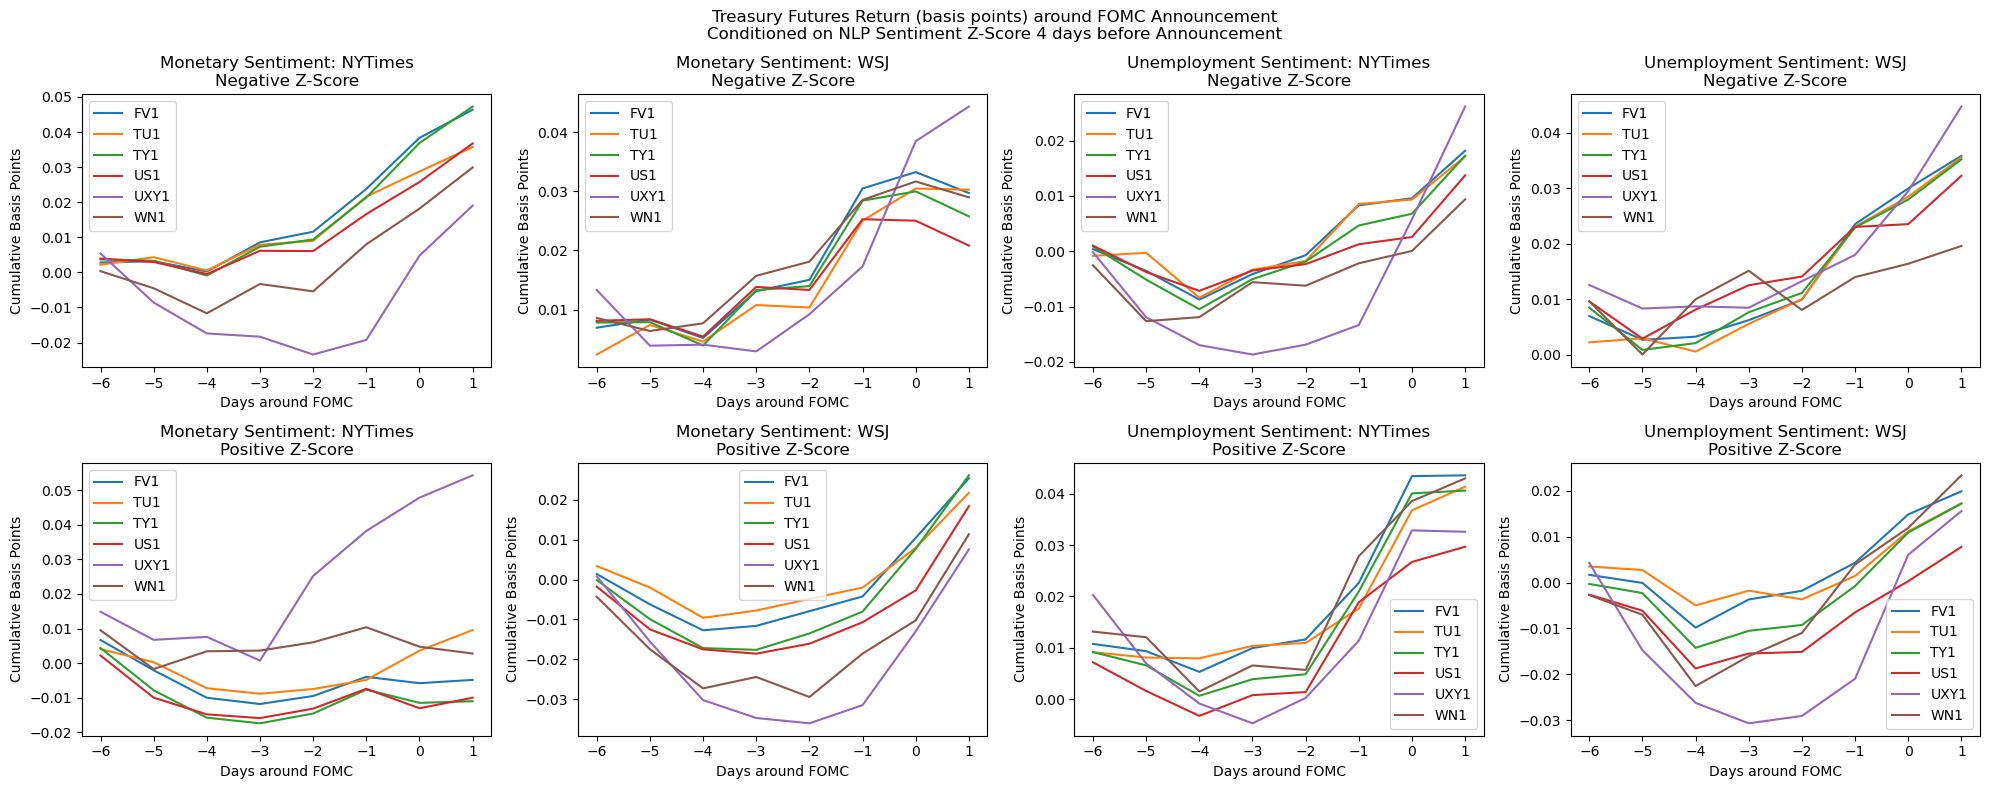

In [232]:
def plot_event_zscore_rtn_playback(df_zscore: pd.DataFrame) -> pd.DataFrame: 
    
    df_plot = (df_zscore.assign(
        group_var = lambda x: x.plot_name.str.replace("\n", "") + "\n" + x.condition).
        sort_values(["condition", "plot_name"]))

    group_vars = df_plot.group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_plot.query(
            "group_var == @group_var")
            [["day", "variable", "PX_bps"]].
            rename(columns = {"variable": ""}).
            pivot(index = "day", columns = "", values = "PX_bps").
            cumsum().
            plot(
                title  = group_var,
                ax     = ax,
                ylabel = "Cumulative Basis Points",
                xlabel = "Days around FOMC"))

    fig.suptitle("Treasury Futures Return (basis points) around FOMC Announcement\nConditioned on NLP Sentiment Z-Score 4 days before Announcement")
    plt.tight_layout()
    
plot_event_zscore_rtn_playback(df_zscore)

It's a little clear why the authors chose not to break out the MAI into different regimes because they have almost comporable returns. From this standpoint this risk premium is simplier in the sense that you there is a compesnation to do the trade before dates 

In this case most of the performance is sub-par the strategies don't consistently make money, have consistent negative returns before giving positive returns and then give back most of their returns toward the end. <br>
With that being the case its not possible to generate different returns per each group. 